In [1]:
import numpy as np, pandas as pd
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [5]:
import sys
import os
os.environ["OMP_NUM_THREADS"] = "1"   # set before importing numpy/xgboost
os.environ["MKL_NUM_THREADS"] = "1"

classes_path = os.path.abspath(r"D:\Repositories\PhD\src\classes")
src_path = os.path.abspath(r"D:\Repositories\PhD\src\functions")
sys.path.append(src_path)
sys.path.append(classes_path)
print(sys.path)

import helpers
import cepstrum_fe

['d:\\Anaconda\\envs\\ml-cpu\\python311.zip', 'd:\\Anaconda\\envs\\ml-cpu\\DLLs', 'd:\\Anaconda\\envs\\ml-cpu\\Lib', 'd:\\Anaconda\\envs\\ml-cpu', '', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages\\win32', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages\\win32\\lib', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages\\Pythonwin', 'D:\\Repositories\\PhD\\src\\functions', 'D:\\Repositories\\PhD\\src\\classes', 'D:\\Repositories\\PhD\\src\\functions', 'D:\\Repositories\\PhD\\src\\classes']


In [10]:
import importlib

In [11]:
importlib.reload(cepstrum_fe)

<module 'cepstrum_fe' from 'D:\\Repositories\\PhD\\src\\classes\\cepstrum_fe.py'>

In [20]:
def extract_features(signal, fs, label,
                     slice_len_s = 2, # slice length in seconds
                     hop_s = 0.25, #percentage overlap
                     frame_len_s=0.25, # Length of the cepstrum frame in seconds
                     frame_hop_s = 0.125, # overlap in seconds
                     quef_search_ms = (0.2, 2000.0), #quefrequency range of the Cepstrum graph
                     lifter_quef_ms = 5.0, # sum energy below lifter_quef_ms for low-quefrequency metric
                     n_ceps = 24, # Keep first n_ceps coefficients (including c0). A simple low-time filter
                     use_complex = False,
                     return_per_frame = False
                     ):
    
    df_slices, df_frames = cepstrum_fe.batch_extract_cepstrum(signal, fs,
                                                              slice_len_s = slice_len_s,
                                                              hop_s = hop_s,
                                                              frame_len_s = frame_len_s,
                                                              frame_hop_s = frame_hop_s,
                                                              quef_search_ms = quef_search_ms,
                                                              lifter_quef_ms = lifter_quef_ms,
                                                              n_ceps=n_ceps,
                                                              use_complex=use_complex,
                                                              return_per_frame=return_per_frame)
    
    df_slices['fault'] = label

    return df_slices

In [25]:
def train_test_validate_model(X, y, feat_names = None):

    X_train, X_test, y_train, y_test = helpers.split_data(X, y, test_size = 0.25, random_state = 42, shuffle = True)
    y_train_pred, y_test_pred, model = helpers.train_and_predict_xgbc(X_train, y_train, X_test)
    roc_train, roc_test, test_thrs = helpers.calculate_roc((y_train, y_test), (y_train_pred, y_test_pred))
    best_thr = helpers.get_best_thr(roc_test[1], roc_test[0], test_thrs)
    y_test_pred_bin = np.where(y_test_pred >= best_thr, 1, 0)
    helpers.plot_roc(roc_train, roc_test, roc_bm = None)
    helpers.print_scores(y_test, y_test_pred_bin)

    if feat_names is not None:
        a = pd.Series(model.feature_importances_)
        b = pd.Series(feat_names)
        feat_importances = pd.concat((a, b), axis = 1)
    
    return model, feat_importances

In [26]:
def train_and_display_dtc(X, y, dominant_feature_name = None):

    dtc = DecisionTreeClassifier(random_state=42)

    if dominant_feature_name is not None:
        X = X[[dominant_feature_name]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

    dtc.fit(X_train, y_train)

    y_test_pred = dtc.predict(X_test)
    helpers.print_scores(y_test, y_test_pred)

    plt.figure(figsize=(12, 8))
    plot_tree(dtc, feature_names=X.columns, class_names=True, filled=True, max_depth=3)
    plt.tight_layout()
    plt.show()

# EE

In [8]:
df = pd.read_csv(r"D:\Repositories\PhD\parsed_data\EE_data\1730_case_edu.csv")
df

,DE,FE,fault_diameter,horse_power,rounds_per_minute,fault_end,samples_per_second,fault_element,fault
0,0.014603,0.192922,0,3,1730,0,12000,0,0
1,0.054449,0.164364,0,3,1730,0,12000,0,0
2,0.107646,0.090811,0,3,1730,0,12000,0,0
3,0.133722,0.086496,0,3,1730,0,12000,0,0
4,0.112652,0.099235,0,3,1730,0,12000,0,0
...,...,...,...,...,...,...,...,...,...
3528365,0.091857,0.155118,21,3,1730,2,48000,1,1
3528366,0.028101,-0.093087,21,3,1730,2,48000,1,1
3528367,-0.061238,-0.144956,21,3,1730,2,48000,1,1
3528368,0.079918,0.077803,21,3,1730,2,48000,1,1


## 1730 RPM; fault end 1; fs 12000; fault element 1; fault diameter 7

In [4]:
de_healthy = df[(df['fault_end'] == 0) & (df['samples_per_second'] == 12000) & (df['fault_element'] == 0) & (df['fault_diameter'] == 0)]['DE']
de_faulty = df[(df['fault_end'] == 1) & (df['samples_per_second'] == 12000) & (df['fault_element'] == 1) & (df['fault_diameter'] == 7)]['DE']

print(de_healthy.shape)
print(de_faulty.shape)

(485643,)
(366988,)


In [21]:
df_fe_healthy = extract_features(de_healthy, 12000, 0,
                                 return_per_frame=False)

In [ ]:
df_fe_healthy

,slice_id,start_s,end_s,duration_s,dom_quef_ms_mean,dom_quef_ms_std,dom_freq_hz_mean,dom_freq_hz_std,cpp_db_mean,cpp_db_std,...,cceps_mean_15,cceps_mean_16,cceps_mean_17,cceps_mean_18,cceps_mean_19,cceps_mean_20,cceps_mean_21,cceps_mean_22,cceps_mean_23,fault
0,0,0.00000,2.00000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.675888,0.436310,...,0.014079,-0.030050,0.060890,-0.006358,0.001068,-0.002427,-0.035594,-0.001861,-0.018017,0
1,1,0.25000,2.25000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.664062,0.370221,...,0.014045,-0.028284,0.059671,-0.006001,0.003057,-0.000726,-0.036108,-0.002976,-0.016586,0
2,2,0.50000,2.50000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.656045,0.372532,...,0.017089,-0.028692,0.056108,-0.002130,0.004133,-0.000626,-0.037740,-0.001926,-0.018716,0
3,3,0.75000,2.75000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.686913,0.373363,...,0.013533,-0.028337,0.055767,-0.001135,0.004513,-0.000036,-0.038667,0.001204,-0.018648,0
4,4,1.00000,3.00000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.698778,0.396243,...,0.016452,-0.029763,0.054793,-0.003842,0.002867,-0.001429,-0.039034,-0.001547,-0.018175,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,150,37.50000,39.50000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.562281,0.404403,...,0.017733,-0.025490,0.048141,0.000865,-0.001507,0.010551,-0.036950,-0.002387,-0.021958,0
151,151,37.75000,39.75000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.689196,0.266752,...,0.019018,-0.025191,0.047408,-0.001095,-0.001378,0.005878,-0.036457,-0.001787,-0.020487,0
152,152,38.00000,40.00000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.605081,0.286824,...,0.016165,-0.025993,0.046417,-0.003730,-0.000241,0.006367,-0.038255,0.001059,-0.021965,0
153,153,38.25000,40.25000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.603081,0.284232,...,0.019182,-0.027560,0.048311,-0.001737,-0.002920,0.002162,-0.038733,-0.000819,-0.025025,0


In [34]:
df_fe_faulty = extract_features(de_faulty, 12000, 1,
                                 return_per_frame=False)
df_fe_faulty

,slice_id,start_s,end_s,duration_s,dom_quef_ms_mean,dom_quef_ms_std,dom_freq_hz_mean,dom_freq_hz_std,cpp_db_mean,cpp_db_std,...,cceps_mean_15,cceps_mean_16,cceps_mean_17,cceps_mean_18,cceps_mean_19,cceps_mean_20,cceps_mean_21,cceps_mean_22,cceps_mean_23,fault
0,0,0.000000,2.000000,2.0,249.833333,8.526513e-14,4.002668,0.0,40.701848,0.513359,...,-0.111373,-0.078395,0.041246,-0.021312,0.062536,-0.085872,0.076157,0.006606,-0.001640,1
1,1,0.250000,2.250000,2.0,249.833333,8.526513e-14,4.002668,0.0,40.665381,0.516952,...,-0.109268,-0.079647,0.042609,-0.022085,0.061831,-0.087512,0.076354,0.005287,-0.002735,1
2,2,0.500000,2.500000,2.0,249.833333,8.526513e-14,4.002668,0.0,40.640518,0.528654,...,-0.110539,-0.080056,0.043199,-0.021273,0.061082,-0.086419,0.078588,0.006831,-0.001571,1
3,3,0.750000,2.750000,2.0,249.833333,8.526513e-14,4.002668,0.0,40.777774,0.530130,...,-0.110300,-0.080712,0.042930,-0.018654,0.059084,-0.084664,0.079838,0.008047,-0.000625,1
4,4,1.000000,3.000000,2.0,249.833333,8.526513e-14,4.002668,0.0,40.729980,0.530187,...,-0.111157,-0.081320,0.043660,-0.016932,0.060066,-0.082838,0.080399,0.010616,-0.001208,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,111,27.750000,29.750000,2.0,249.833333,8.526513e-14,4.002668,0.0,40.892217,0.436623,...,-0.102290,-0.136252,-0.018174,0.059885,0.067684,-0.061482,0.027562,-0.028419,-0.007399,1
112,112,28.000000,30.000000,2.0,249.833333,8.526513e-14,4.002668,0.0,41.043554,0.507030,...,-0.103644,-0.138522,-0.019652,0.057942,0.067841,-0.062059,0.024864,-0.027694,-0.008149,1
113,113,28.250000,30.250000,2.0,249.833333,8.526513e-14,4.002668,0.0,41.042071,0.514180,...,-0.102563,-0.136257,-0.020030,0.058566,0.068776,-0.062147,0.025181,-0.029504,-0.009074,1
114,114,28.500000,30.500000,2.0,249.833333,8.526513e-14,4.002668,0.0,41.033159,0.474644,...,-0.099991,-0.136160,-0.020113,0.058443,0.067072,-0.064730,0.024832,-0.030680,-0.010478,1


In [35]:
overall_df = pd.concat((df_fe_healthy, df_fe_faulty))
overall_df

,slice_id,start_s,end_s,duration_s,dom_quef_ms_mean,dom_quef_ms_std,dom_freq_hz_mean,dom_freq_hz_std,cpp_db_mean,cpp_db_std,...,cceps_mean_15,cceps_mean_16,cceps_mean_17,cceps_mean_18,cceps_mean_19,cceps_mean_20,cceps_mean_21,cceps_mean_22,cceps_mean_23,fault
0,0,0.000000,2.000000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.675888,0.436310,...,0.014079,-0.030050,0.060890,-0.006358,0.001068,-0.002427,-0.035594,-0.001861,-0.018017,0
1,1,0.250000,2.250000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.664062,0.370221,...,0.014045,-0.028284,0.059671,-0.006001,0.003057,-0.000726,-0.036108,-0.002976,-0.016586,0
2,2,0.500000,2.500000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.656045,0.372532,...,0.017089,-0.028692,0.056108,-0.002130,0.004133,-0.000626,-0.037740,-0.001926,-0.018716,0
3,3,0.750000,2.750000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.686913,0.373363,...,0.013533,-0.028337,0.055767,-0.001135,0.004513,-0.000036,-0.038667,0.001204,-0.018648,0
4,4,1.000000,3.000000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.698778,0.396243,...,0.016452,-0.029763,0.054793,-0.003842,0.002867,-0.001429,-0.039034,-0.001547,-0.018175,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,111,27.750000,29.750000,2.0,249.833333,8.526513e-14,4.002668,0.000000e+00,40.892217,0.436623,...,-0.102290,-0.136252,-0.018174,0.059885,0.067684,-0.061482,0.027562,-0.028419,-0.007399,1
112,112,28.000000,30.000000,2.0,249.833333,8.526513e-14,4.002668,0.000000e+00,41.043554,0.507030,...,-0.103644,-0.138522,-0.019652,0.057942,0.067841,-0.062059,0.024864,-0.027694,-0.008149,1
113,113,28.250000,30.250000,2.0,249.833333,8.526513e-14,4.002668,0.000000e+00,41.042071,0.514180,...,-0.102563,-0.136257,-0.020030,0.058566,0.068776,-0.062147,0.025181,-0.029504,-0.009074,1
114,114,28.500000,30.500000,2.0,249.833333,8.526513e-14,4.002668,0.000000e+00,41.033159,0.474644,...,-0.099991,-0.136160,-0.020113,0.058443,0.067072,-0.064730,0.024832,-0.030680,-0.010478,1


In [36]:
overall_df = overall_df.sample(frac=1)
X = overall_df.iloc[:, :-1]
y = overall_df.iloc[:, -1]

In [37]:
y.value_counts()

fault
0    155
1    116
Name: count, dtype: int64

In [38]:
overall_df.columns[:-1]

Index(['slice_id', 'start_s', 'end_s', 'duration_s', 'dom_quef_ms_mean',
       'dom_quef_ms_std', 'dom_freq_hz_mean', 'dom_freq_hz_std', 'cpp_db_mean',
       'cpp_db_std', 'low_q_energy_db_mean', 'low_q_energy_db_std',
       'cceps_mean_0', 'cceps_mean_1', 'cceps_mean_2', 'cceps_mean_3',
       'cceps_mean_4', 'cceps_mean_5', 'cceps_mean_6', 'cceps_mean_7',
       'cceps_mean_8', 'cceps_mean_9', 'cceps_mean_10', 'cceps_mean_11',
       'cceps_mean_12', 'cceps_mean_13', 'cceps_mean_14', 'cceps_mean_15',
       'cceps_mean_16', 'cceps_mean_17', 'cceps_mean_18', 'cceps_mean_19',
       'cceps_mean_20', 'cceps_mean_21', 'cceps_mean_22', 'cceps_mean_23'],
      dtype='object')

F1: 1.000
Accuracy: 1.000
Precision: 1.000
ROC AUC: 1.000
Recall: 1.000


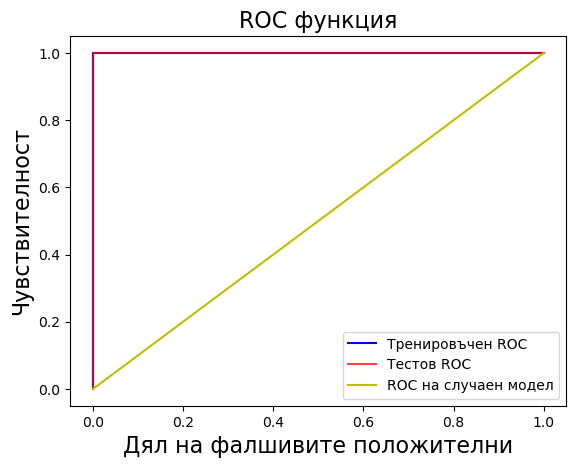

In [39]:
xgbc_cep_1730_7, feat_importances = train_test_validate_model(X, y, overall_df.columns[:-1])

In [40]:
feat_importances

,0,1
0,0.0,slice_id
1,0.0,start_s
2,0.0,end_s
3,0.0,duration_s
4,1.0,dom_quef_ms_mean
5,0.0,dom_quef_ms_std
6,0.0,dom_freq_hz_mean
7,0.0,dom_freq_hz_std
8,0.0,cpp_db_mean
9,0.0,cpp_db_std


F1: 1.000
Accuracy: 1.000
Precision: 1.000
ROC AUC: 1.000
Recall: 1.000


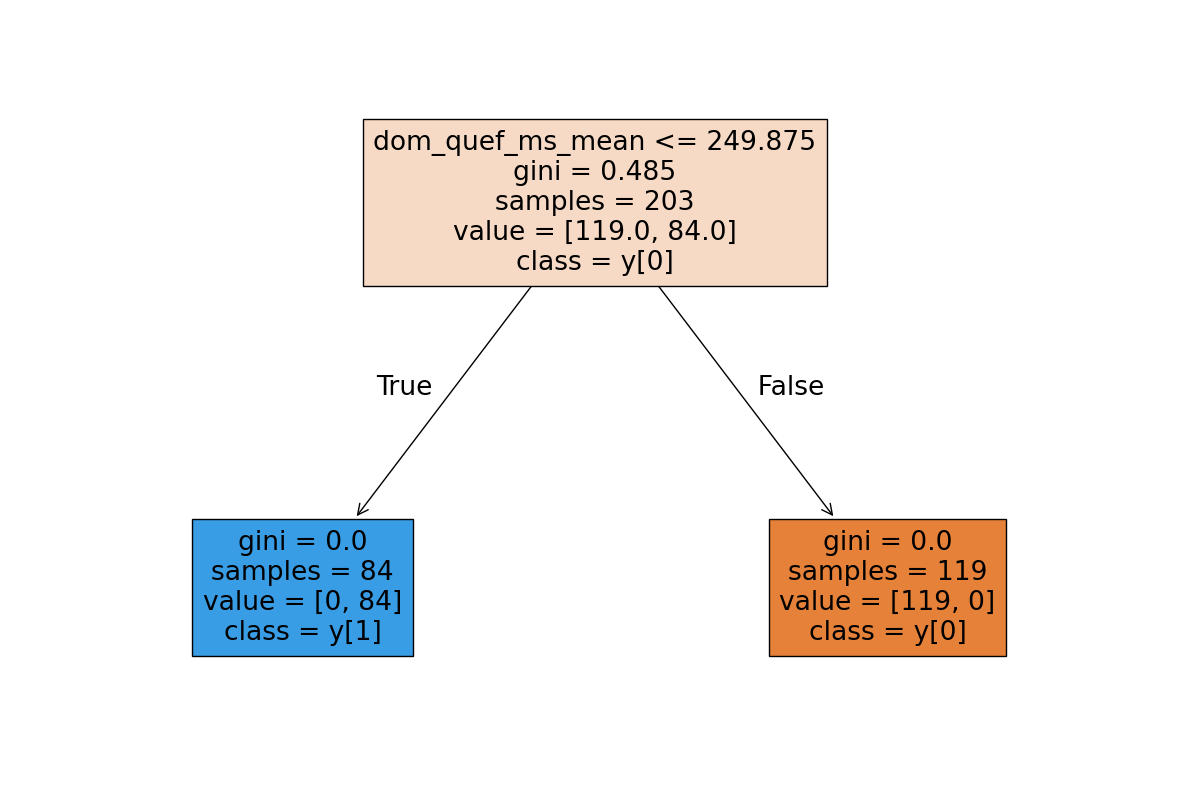

In [41]:
train_and_display_dtc(X, y, 'dom_quef_ms_mean')

## 1730 RPM; fault end 1; fs 12000; fault element 1; fault diameter 21

## 1797 RPM; fault end 1; fs 12000; fault element 1; fault diameter 7

## 1797 RPM; fault end 1; fs 12000; fault element 1; fault diameter 21

# ICE

## 1000 RPM; 50% Humidity; 30 C Temp

## 1500 RPM; 50% Humidity; 30 C Temp

## 2000 RPM; 50% Humidity; 30 C Temp